В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
!pip install opendatasets --upgrade --quiet

In [3]:
import pandas as pd
import numpy as np
import opendatasets as od
import os
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from lightgbm import LGBMClassifier

In [4]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets


def compute_auroc(model, inputs, targets):
  y_pred = model.predict_proba(inputs)[:, 1]

  return roc_auc_score(targets, y_pred)

In [5]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data?select=train.csv'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiiakhartynova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 74.8MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [17]:
data_dir = './bank-customer-churn-prediction-dlu'
train_csv = data_dir + '/train.csv'
test_csv =  data_dir + '/test.csv'
sample_submission_csv =  data_dir + '/sample_submission.csv'

In [18]:
raw_df = pd.read_csv(train_csv)

target_col = 'Exited'
input_cols = list(raw_df.columns)
cols_to_drop = ['Exited', 'id', 'CustomerId', 'Surname']
input_cols = list(filter(lambda x: x not in cols_to_drop, input_cols))

train_df, val_df = split_train_val(raw_df, target_col)
train_X, train_y = separate_inputs_targets(train_df, input_cols, target_col)
val_X, val_y = separate_inputs_targets(val_df, input_cols, target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [19]:
categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()

train_X[categorical_cols] = train_X[categorical_cols].astype('category')
val_X[categorical_cols] = val_X[categorical_cols].astype('category')

In [20]:
train_X.info(), val_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      12000 non-null  float64 
 1   Geography        12000 non-null  category
 2   Gender           12000 non-null  category
 3   Age              12000 non-null  float64 
 4   Tenure           12000 non-null  float64 
 5   Balance          12000 non-null  float64 
 6   NumOfProducts    12000 non-null  float64 
 7   HasCrCard        12000 non-null  float64 
 8   IsActiveMember   12000 non-null  float64 
 9   EstimatedSalary  12000 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 867.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6490 to 3024
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      3000 non-null   float64 
 1   Geography        3000 no

(None, None)

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [12]:
xgb = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,
    use_label_encoder=False,
    device='cuda',
    random_state=42
)

xgb.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
print('Train AUROC', compute_auroc(xgb, train_X, train_y))
print('Validation AUROC', compute_auroc(xgb, val_X, val_y))

Train AUROC 0.934430985513848
Validation AUROC 0.933416901022018


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:05:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Модель має дуже хороші результати (з покращенням скору майже на 1 в порівнянні з моєю найкращою моделлю Decision Tree) + результати на тренувальних і валідаційних даних дуже близькі, що свідчить про те, що вона добре генералізує на нових, невідомих даних.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [21]:
# Function that specifies objective
def objective(model_class, param_space, params, **model_specific_params):
    # Convert hyperopt params to the correct types if necessary
    model_params = {key: int(value) if key in param_space['int_params'] else value for key, value in params.items()}

    # Initialize the model
    model = model_class(**model_params, **model_specific_params, random_state=42)

    # Fit the model
    try:
        model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
    except TypeError:
        model.fit(train_X, train_y, eval_set=[(val_X, val_y)])

    # Compute the AUROC
    auroc = compute_auroc(model, val_X, val_y)

    return {'loss': -auroc, 'status': STATUS_OK}


# Wrapper function for hyperopt for XGB
def hyperopt_objective_XGB(params):
    return objective(XGBClassifier, param_space, params, enable_categorical=True)


# Function to find best hyperparameters
def optimize_hyperopt_params(objective, space, int_params, max_evals):
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=Trials())
    # Convert hyperparameter values to final types
    for key in int_params:
      best[key] = int(best[key])

    print("Best hyperparameters: ", best)

    return best

In [43]:
param_space = {
    'params': {
        'n_estimators': hp.quniform('n_estimators', 10, 500, 25),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'max_depth': hp.quniform('max_depth', 1, 15, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1)
    },
    'int_params': ['n_estimators', 'max_depth', 'min_child_weight']  # List of params that need to be converted to int
}

# Find best hyperparameters for XGB Classifier
best = optimize_hyperopt_params(hyperopt_objective_XGB, param_space['params'], param_space['int_params'], max_evals=20)

100%|██████████| 20/20 [00:13<00:00,  1.47trial/s, best loss: -0.93732834899513]
Best hyperparameters:  {'colsample_bytree': 0.8149774609861837, 'gamma': 0.4724294804749656, 'learning_rate': 0.06966595539293906, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 125, 'reg_alpha': 0.38468827216350854, 'reg_lambda': 0.16685754630617977, 'subsample': 0.8892355013278412}


In [45]:
# Final model with the best parameters
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    device='cuda',
    random_state=42
)

final_clf.fit(train_X, train_y)

print('Train AUROC', compute_auroc(final_clf, train_X, train_y))
print('Validation AUROC', compute_auroc(final_clf, val_X, val_y))

Train AUROC 0.9423159891615636
Validation AUROC 0.9377498456684272


Результат моделі на валідаційних даних ще трохи покращився, і модель все ще чудово перформить на обох наборах даних.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [22]:
cat_col_indices = [train_X.columns.get_loc(col) for col in categorical_cols]

lgb = LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_col_indices
)

lgb.fit(train_X, train_y, eval_set=[(val_X, val_y)])

print('Train AUROC', compute_auroc(lgb, train_X, train_y))
print('Validation AUROC', compute_auroc(lgb, val_X, val_y))

[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Ця модель також видає чудові результати, вони дуже подібні до попередньої моделі.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [ ]:
# Wrapper function for hyperopt for LGBM
def hyperopt_objective_lgbm(params):
    return objective(LGBMClassifier, param_space, params, cat_feature=cat_col_indices)


param_space = {
    'params': {
      'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
      'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
      'max_depth': hp.quniform('max_depth', 1, 15, 1),
      'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
      'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
      'subsample': hp.uniform('subsample', 0.5, 1.0),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
      'reg_alpha': hp.uniform('reg_alpha', 0, 1),
      'reg_lambda': hp.uniform('reg_lambda', 0, 1),
      'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
 },
    'int_params': ['n_estimators', 'max_depth', 'num_leaves']  # List of params that need to be converted to int
}

# Find best hyperparameters for LGBM Classifier
best_lgbm = optimize_hyperopt_params(hyperopt_objective_lgbm, param_space['params'], param_space['int_params'], max_evals=10)

In [24]:
# Final model with the best parameters
final_lgb_clf = LGBMClassifier(
    n_estimators=best_lgbm['n_estimators'],
    learning_rate=best_lgbm['learning_rate'],
    max_depth=best_lgbm['max_depth'],
    num_leaves=best_lgbm['num_leaves'],
    min_child_weight=best_lgbm['min_child_weight'],
    subsample=best_lgbm['subsample'],
    colsample_bytree=best_lgbm['colsample_bytree'],
    reg_alpha=best_lgbm['reg_alpha'],
    reg_lambda=best_lgbm['reg_lambda'],
    min_split_gain=best_lgbm['min_split_gain'],
    cat_feature=cat_col_indices,
    random_state=42
)

final_lgb_clf.fit(train_X, train_y)

print('Train AUROC', compute_auroc(final_lgb_clf, train_X, train_y))
print('Validation AUROC', compute_auroc(final_lgb_clf, val_X, val_y))

[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Ця модель теж видає чудові і дуже подібні результати до попередніх.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

Найкращий результат показує модель final_clf - XGBoostClassifier з гіперпараметрами знайденими за допомогою Hyperopt.

In [ ]:
test_raw_df = pd.read_csv(test_csv)
test_X = test_raw_df[input_cols]
test_X[categorical_cols] = test_X[categorical_cols].astype('category')
probas = final_clf.predict_proba(test_X)

In [46]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Machine Learning/Data/'
os.chdir(dir)

Mounted at /content/drive


In [85]:
submission = pd.read_csv(sample_submission_csv)
submission.Exited = probas[:,1]
submission.head()
submission.to_csv('submission_xgb_hyperopt.csv', index=False)

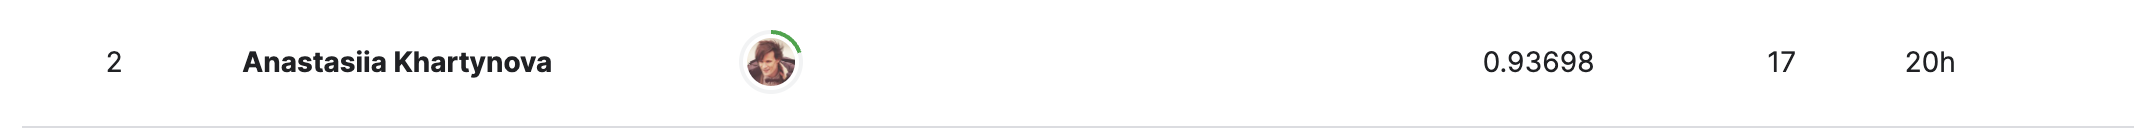